In [2]:
import gcsfs #module for google cloud connection
import os
import allel
import zarr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pyfasta

In [3]:
gcs_orig = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache')
gcs =  gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token=gcs_orig.session.credentials)

In [4]:
 ###### Adding phase2 haplotype path ######
phase2path = os.path.join("ag1000g-release", "phase2.AR1", "haplotypes", "main", "zarr", "ag1000g.phase2.ar1.haplotypes")
gcsmap2 = gcsfs.mapping.GCSMap(phase2path, gcs=gcs)
calldata_phase2= zarr.Group(gcsmap2, read_only=True)

In [5]:
###### loading phase2 metadata ######
metadata = pd.read_csv("samples.meta.txt", sep="\t")
pop_select = metadata.population.isin({'BFcol', 'BFgam'}).values
pop_subset = metadata[pop_select]

In [6]:
access_path = os.path.join("ag1000g-release", "phase2.AR1", "accessibility", "accessibility.zarr")
gcsmap3 = gcsfs.mapping.GCSMap(access_path, gcs=gcs)
accessibility_phase2= zarr.Group(gcsmap3, read_only=True)

In [7]:
genotypes_phase2_call = calldata_phase2['3R']["calldata/GT"]
genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)

In [8]:
geno_p2_subset

<GenotypeChunkedArray shape=(10752701, 167, 2) dtype=int8 chunks=(10501, 167, 2)
   nbytes=3.3G cbytes=162.2M cratio=21.1
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [9]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [10]:
ac_subpops

<AlleleCountsChunkedTable shape=(10752701,) dtype=[('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,))]
   nbytes=164.1M cbytes=20.7M cratio=7.9
   values=allel.chunked.storage_zarr.ZarrTable>

In [11]:
pos = calldata_phase2['3R']['variants']['POS'][:]    
pos.shape

(10752701,)

In [12]:
pos = allel.SortedIndex(pos, copy=False)
pos

0,1,2,3,4,...,10752696,10752697,10752698,10752699,10752700
9526,9531,9544,9546,9549,...,53195257,53195262,53195269,53195273,53195279


In [13]:
pos.max()

53195279

In [14]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['BFcol'], ac_subpops['BFgam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max(),
                                                             )

(0, 0.018)

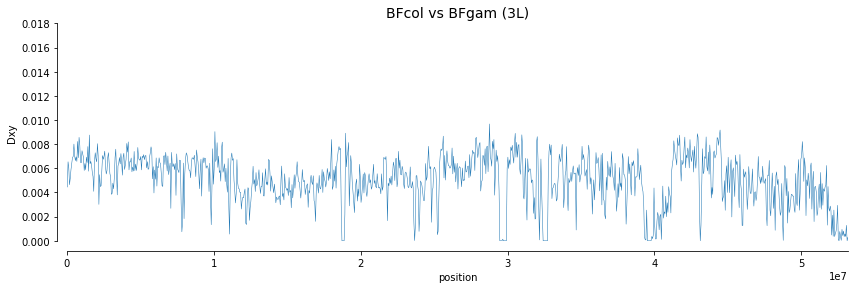

In [15]:
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5)
ax.set_xlim(0, pos.max())
ax.set_title('%s vs %s (%s)' % ('BFcol', 'BFgam', '3L'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)

-------------------------------

## Create the Dxy function

In [16]:
def plot_dxy(pop1, pop2, chrom, window_size=20000, min_n_bases=1):
    metadata = pd.read_csv("samples.meta.txt", sep="\t")
    pop_select = metadata.population.isin({pop1,pop2}).values
    pop_subset = metadata[pop_select]
    genotypes_phase2_call = calldata_phase2[chrom]["calldata/GT"]
    genotypes_phase2 = allel.GenotypeChunkedArray(genotypes_phase2_call)
    geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)
    grp = pop_subset.groupby("population")
    grp_indices = grp.indices
    ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)
    ac1 = ac_subpops[pop1]
    ac2 = ac_subpops[pop2]
    pos = calldata_phase2[chrom]['variants']['POS'][:]    
    dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac1, ac2, 
                                                                    size=window_size, 
                                                                    start=1, 
                                                                    stop=pos.max()
                                                             )
    x = np.mean(windows[n_bases >= min_n_bases], axis=1)
    y = dxy[n_bases >= min_n_bases]
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y, lw=.5)
    ax.set_xlim(0, pos.max())
    ax.set_title('%s vs %s (%s)' % (pop1, pop2, chrom), fontsize=14)
    ax.set_ylabel('Dxy')
    ax.set_xlabel('position')
    ax.set_ylim(0,0.018)    

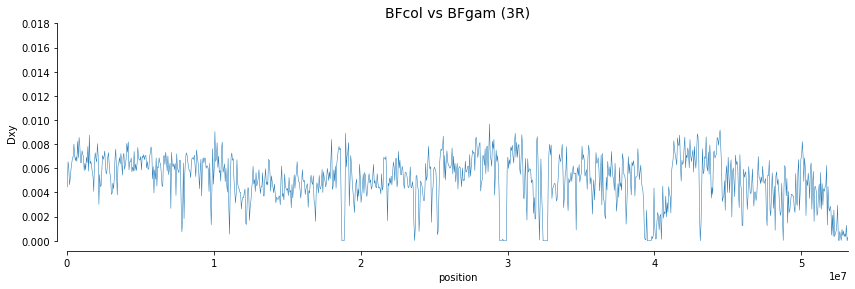

In [17]:
plot_dxy('BFcol', 'BFgam', '3R',  window_size=50000, min_n_bases=1000)

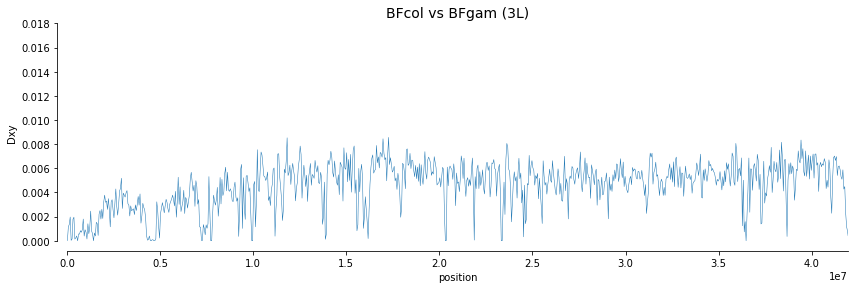

In [18]:
plot_dxy('BFcol', 'BFgam', '3L',  window_size=50000, min_n_bases=1000)

-----------------------------------------------

--------------------------------------

## Sandbox

In [18]:
fasta_fn = 'Anopheles-gambiae-PEST_CHROMOSOMES_AgamP3.fa'
genome = pyfasta.Fasta(fasta_fn, key_fn=lambda k: k.split()[0])

In [19]:
seq = np.asarray(genome['3L'])

In [28]:
seq.size, pos.max()

(41963435, 53195279)

(0, 0.018)

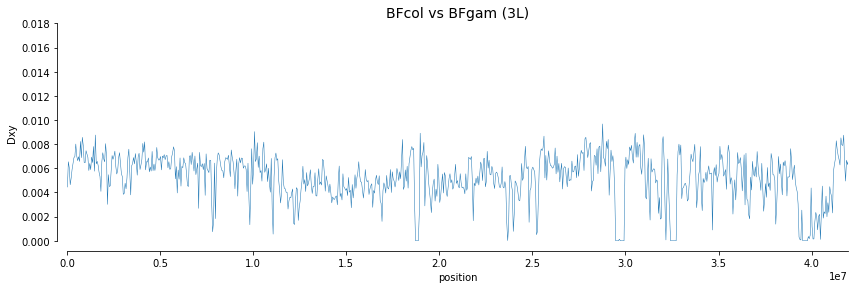

In [29]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['BFcol'], ac_subpops['BFgam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=seq.size
                                                             )
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5)
ax.set_xlim(0, seq.size)
ax.set_title('%s vs %s (%s)' % ('BFcol', 'BFgam', '3L'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)

(0, 0.018)

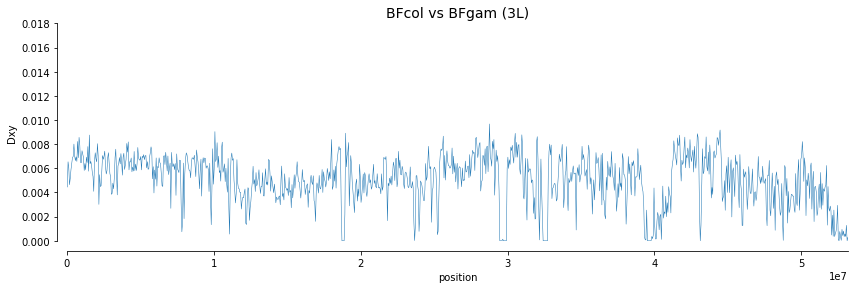

In [25]:
dxy, windows, n_bases, counts = allel.windowed_divergence(pos, ac_subpops['BFcol'], ac_subpops['BFgam'], 
                                                                    size=50000, 
                                                                    start=1, 
                                                                    stop=pos.max()
                                                             )
min_n_bases=1
x = np.mean(windows[n_bases >= min_n_bases], axis=1)
y = dxy[n_bases >= min_n_bases]
fig, ax = plt.subplots(figsize=(14, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y, lw=.5)
ax.set_xlim(0, pos.max())
ax.set_title('%s vs %s (%s)' % ('BFcol', 'BFgam', '3L'), fontsize=14)
ax.set_ylabel('Dxy')
ax.set_xlabel('position')
ax.set_ylim(0,0.018)